![Logo](logo.jpg)

# Swin Transformer for Flower Classification

## Overview
This code implements a flower classification system using the Swin Transformer architecture, specifically trained on the Oxford Flowers-102 dataset. The implementation includes data preprocessing, model training, and visualization utilities.


In [25]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformers import SwinForImageClassification
import time
import numpy as np

### Setup:
- Device selection (CUDA/MPS/CPU)
- Data augmentation for training:
  - Random horizontal flips
  - Random rotations
  - Color jittering
  - Random affine transformations
- Test data normalization

### Dataset Preparation:
- Loads Oxford Flowers-102 dataset
- Splits training data into train/validation sets (80/20)
- Creates DataLoader instances with appropriate batch sizes
- Implements data augmentation for training

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Oxford Flowers-102 dataset
train_dataset = torchvision.datasets.Flowers102(
    root='./data',
    split='train',
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.Flowers102(
    root='./data',
    split='test',
    download=True,
    transform=test_transform
)

# Create validation set from train set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print(f"Number of classes: 102")



Using device: mps
Number of training images: 816
Number of validation images: 204
Number of test images: 6149
Number of classes: 102


#### a) `denormalize(tensor)`:
- Converts normalized tensors back to image format
- Handles different tensor dimensions (single image vs batch)
- Applies inverse normalization using ImageNet statistics
- Ensures proper tensor shape management

#### b) `show_sample_images(dataloader, num_images=5, title="Sample Images")`:
- Displays sample images from the dataset
- Handles image denormalization
- Shows class labels for each image
- Creates a grid of images with proper formatting


Showing sample training images:


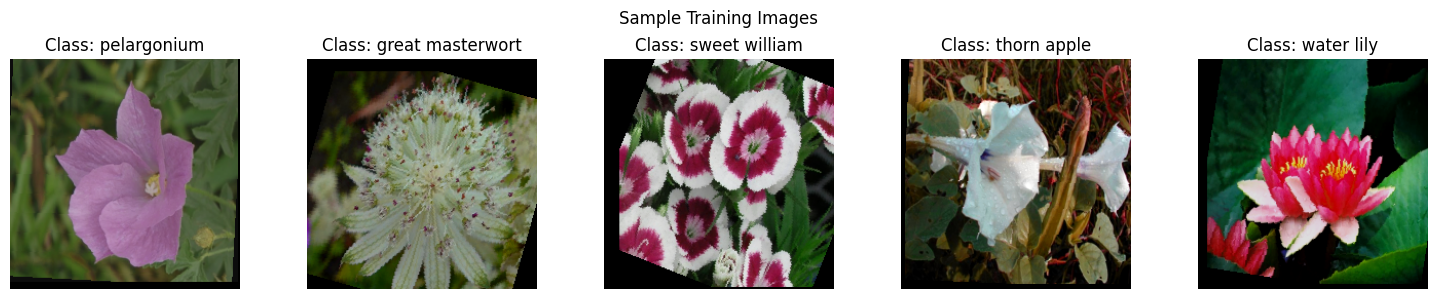

In [27]:
def denormalize(tensor):
    """Convert normalized tensor back to image"""
    # Ensure tensor is on CPU and has correct dimensions
    tensor = tensor.cpu()
    if len(tensor.shape) == 3:  # If single image (C, H, W)
        tensor = tensor.unsqueeze(0)  # Add batch dimension
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    # Denormalize
    tensor = tensor * std + mean
    
    # Remove batch dimension if it was added
    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    return tensor
def show_sample_images(dataloader, num_images=5, title="Sample Images"):
    """Display sample images from the dataset"""
    # Get a batch of images
    images, labels = next(iter(dataloader))
    
    # Create a figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(title)
    
    # Get class names
    class_names = dataloader.dataset.dataset.classes if hasattr(dataloader.dataset, 'dataset') else dataloader.dataset.classes
    
    for i in range(min(num_images, len(images))):  # Ensure we don't exceed batch size
        # Denormalize image
        img = denormalize(images[i])
        img = img.numpy().transpose(1, 2, 0)  # Convert to HWC format
        img = np.clip(img, 0, 1)
        
        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[labels[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images before training
print("\nShowing sample training images:")
show_sample_images(train_loader, num_images=5, title="Sample Training Images")

Model Configuration:
- Loads pretrained Swin Transformer (tiny variant)
- Adapts model for 102 flower classes
- Implements transfer learning:
  - Freezes most layers
  - Only trains last layer and classifier
- Reports parameter statistics

In [28]:
# Load pretrained model
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    num_labels=102,  # Flowers-102 has 102 classes
    ignore_mismatched_sizes=True
).to(device)

# Freeze all layers except the last few
for name, param in model.named_parameters():
    if "classifier" not in name and "layers.3" not in name:  # Train last layer and classifier
        param.requires_grad = False

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([102, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 14,262,294 (51.68% of total)


Training Process:
- Implements the training loop with:
  - CrossEntropyLoss as the loss function
  - AdamW optimizer with weight decay
  - Cosine learning rate scheduling
  - Model checkpointing (saves best model)
- Tracks:
  - Training losses
  - Test accuracies
  - Best model performance
- Includes progress reporting and timing

In [29]:
def train_model(model, train_loader, test_loader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    train_losses = []
    test_accuracies = []
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'swin_transformer_flowers_best.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, '
              f'Test Accuracy: {accuracy:.2f}%, Best Accuracy: {best_accuracy:.2f}%, '
              f'Time: {epoch_time:.2f}s')
    
    return train_losses, test_accuracies

## Train model

Training Process:
- Executes model training
- Shows sample images before training
- Displays training progress
- Visualizes results
- Shows predictions on test set

In [30]:
# Train model
train_losses, test_accuracies = train_model(model, train_loader, test_loader, device, num_epochs=5)

Epoch [1/5], Loss: 4.5204, Test Accuracy: 11.99%, Best Accuracy: 11.99%, Time: 129.60s
Epoch [2/5], Loss: 3.5643, Test Accuracy: 41.50%, Best Accuracy: 41.50%, Time: 131.17s
Epoch [3/5], Loss: 2.2687, Test Accuracy: 59.90%, Best Accuracy: 59.90%, Time: 132.28s
Epoch [4/5], Loss: 1.4915, Test Accuracy: 67.83%, Best Accuracy: 67.83%, Time: 129.57s
Epoch [5/5], Loss: 1.1876, Test Accuracy: 70.55%, Best Accuracy: 70.55%, Time: 131.56s


In [31]:
def plot_results(train_losses, test_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2.plot(test_accuracies)
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

`show_predictions(model, dataloader, device, num_images=5)`:
- Visualizes model predictions on test images
- Shows both predicted and true labels
- Uses color coding (green/red) to indicate correct/incorrect predictions
- Displays images in a grid format

In [32]:
def show_predictions(model, dataloader, device, num_images=5):
    """Display model predictions on sample images"""
    model.eval()
    images, labels = next(iter(dataloader))
    # Randomly select num_images from the batch
    if len(images) > num_images:
        indices = torch.randperm(len(images))[:num_images]
        images = images[indices]
        labels = labels[indices]
        
    images = images.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
    
    # Create a figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle("Model Predictions")
    
    # Get class names
    class_names = dataloader.dataset.dataset.classes if hasattr(dataloader.dataset, 'dataset') else dataloader.dataset.classes
    
    for i in range(min(num_images, len(images))):  # Ensure we don't exceed batch size
        # Denormalize image
        img = denormalize(images[i])
        img = img.numpy().transpose(1, 2, 0)  # Convert to HWC format
        img = np.clip(img, 0, 1)
        
        # Display image with prediction
        axes[i].imshow(img)
        pred_class = class_names[predicted[i]]
        true_class = class_names[labels[i]]
        color = 'green' if predicted[i] == labels[i] else 'red'
        axes[i].set_title(f"Pred: {pred_class}\nTrue: {true_class}", color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## Plot training results

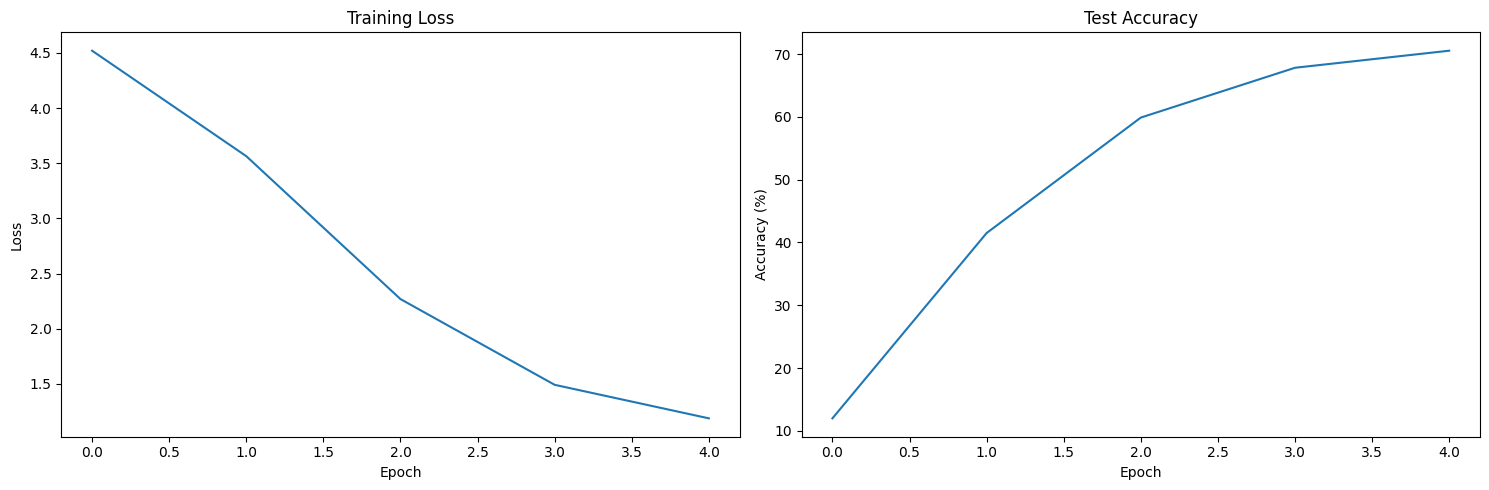

In [33]:
# Plot training results
plot_results(train_losses, test_accuracies)



## Show predictions on test set


Showing model predictions on test images:


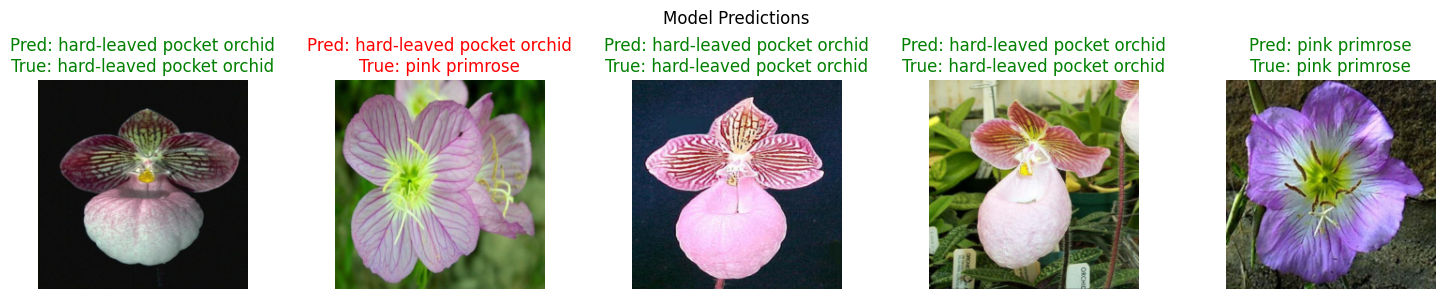

In [34]:
# Show predictions on test set
print("\nShowing model predictions on test images:")
show_predictions(model, test_loader, device, num_images=5)